In [1]:
import visualization as vis
%run 00_analysis_config.ipynb

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
import numpy as np
import pylorentz
import random

DATA_DIR    = "/project/def-mdiamond/tomren/mathusla/data/"

In [3]:
def line_cube_intersect(line_P0, line_P1,cube_vertex_xyz, cube_length_xyz, cube_ex, cube_ey, cube_ez):
    """
    Find the intersection of a line and a cube
    
    Line is defined as r(t) = line_P0 + line_P1*t
    Cube is given with 5 variables:
     cube_vertex_xyz: [x0,y0,z0], One vertex of the cube
     cube_length_xyz: [lenth_x,lenth_y,lenth_z]
     cube_ex, cube_ey,cube_ez: [ex1,ey1,ez1], unit vectors of the three sides of the cube
     
    Return:
    ---
    v1,v2: coordinates of the two intersect point.
    If v1==v2==0, there is no intersection.
    
    Test:
    ---
    line_cube_intersect([0,0,0], [2,0,1], [2,2,0],[4,1,2], [-1,0,0],[0,-1,0],[0,0,1] )
    
    """
    
    P0 = np.array(line_P0)
    P1 = np.array(line_P1)
    A = np.array(cube_vertex_xyz)
    
    dot1 = P1@cube_ex
    dot2 = (A-P0)@cube_ex
    if dot1!=0:
        tmin_x = dot2/dot1     if dot1>0 else (cube_length_xyz[0]+dot2)/dot1
        tmax_x = (cube_length_xyz[0]+dot2)/dot1 if dot1>0 else dot2/dot1
    else:
        tmin_x=tmax_x=np.inf
    
    dot1 = P1@cube_ey
    dot2 = (A-P0)@cube_ey
    if dot1!=0:
        tmin_y = dot2/dot1     if dot1>0 else (cube_length_xyz[1]+dot2)/dot1
        tmax_y = (cube_length_xyz[1]+dot2)/dot1 if dot1>0 else dot2/dot1
    else:
        tmin_y=tmax_y=np.inf        
    
    dot1 = P1@cube_ez
    dot2 = (A-P0)@cube_ez
    if dot1!=0:
        tmin_z = dot2/dot1     if dot1>0 else (cube_length_xyz[2]+dot2)/dot1
        tmax_z = (cube_length_xyz[2]+dot2)/dot1 if dot1>0 else dot2/dot1    
    else:
        tmin_z=tmax_z=np.inf        
        
    tmins = np.array([tmin_x,tmin_y,tmin_z])
    tmaxs = np.array([tmax_x,tmax_y,tmax_z])
    tmin  = np.max(tmins[abs(tmins)!=np.inf])
    tmax  = np.min(tmaxs[abs(tmaxs)!=np.inf])
    
    if tmax<tmin:
        return np.array([0,0,0]),np.array([0,0,0])
    else:
        return P0+tmin*P1, P0+tmax*P1
    
def read_decay_file(filename):
    llp_decay=[]
    with open(filename_products ,"r") as f:
        for line in f:
            line = line.split(",")
            # Attach a new event
            if len(line)==6:
                llp_decay.append([])
            elif len(line)==7:
                llp_decay[-1].append([float(line[0]),float(line[1]),float(line[2]),float(line[3]),int(float(line[-2]))])            
                
    return llp_decay    


def frame_transform(four_vector_in, boost_direction, beta=None, gamma=None):
    """
    Transform the four-vector (e, p_x, p_y, p_z,) with boost_direction and beta/gamma.
    
    INPUT:
    ---
    e, p_x, p_y, p_z: 
        four-vector to be transformed. Can be momentum or what ever 4-vector
    boost_direction:
        three-vector, the relative velocity of the frame to be transformed to
    beta/gamma:
        at least one needs to be given
        
    RETURN
    ---
    four_vector_out:
        the transformed four-vector
    """
    x, y, z = boost_direction
    e, p_x, p_y, p_z = four_vector_in
    four_vector_out = pylorentz.Momentum4(e, p_x, p_y, p_z).boost(x, y, z, beta=beta, gamma=gamma)
    return four_vector_out
    

In [5]:
# def process_siminput()



N_MC = 10000
mX=15     # GeV
ctau=1000 #m
rand_seed = 1
nprint=1000


filename_llp4vec = f"{DATA_DIR}/MATHUSLA_LLPfiles_HXX/All_HXX_LLP4vectors/HXX_LLP4vectors_mX_{mX}_2perevent_unweighted.csv"
filename_products = f"{DATA_DIR}/H_hadronic_decays_geant/bb_{mX}.txt"
filename_output = f"scripts/LLP_test_bb_{mX}.txt"


rng = np.random.default_rng(seed=rand_seed)
random.seed(rand_seed)

# Decay volume geometry
surface_height = 85.47
volume_floor_height = surface_height-19
volume_top_height = surface_height+6
full_module_width=100
module_to_CMS = 70
# The following xyz are all in CMS coordinate!
cube_vertex_xyz = [full_module_width/2, volume_floor_height, module_to_CMS]
cube_length_xyz = [full_module_width, volume_top_height-volume_floor_height, full_module_width]
cube_ex = [-1, 0, 0 ]
cube_ey = [0, 1, 0]
cube_ez = [0, 0, 1 ]

theta_range = np.array([np.arctan(volume_top_height/module_to_CMS),np.arctan(volume_floor_height/(module_to_CMS+full_module_width))])
eta_range = -np.log(np.tan(theta_range/2))
phi_range = np.array([-np.arctan(full_module_width*0.5/volume_floor_height),np.arctan(full_module_width*0.5/volume_floor_height)])

# Load the LLP 4-vector
print("Reading LLP 4-vector file")
p4vec = np.loadtxt(filename_llp4vec,delimiter=",", dtype=float)
print("Reading LLP decay product file")
llp_decay = read_decay_file(filename_products)

Reading LLP 4-vector file
Reading LLP decay product file


In [8]:
#-----------------------------
f_out = open(filename_output,"w+")
# weight 1,2
N_LLP = len(p4vec)
N_decay = len(llp_decay)
weight1 = N_LLP/N_MC
weight2 = (phi_range[1]-phi_range[0])/2/np.pi

# Sample events
if N_MC>=N_decay:
    N_MC=N_decay
    i_decay_list = np.arange(N_MC)
else:
    # Get random index for decay sample
    i_decay_list=random.sample(range(N_decay), N_MC)
    
print(f"Selecting {N_MC} events out of {N_decay}")


n_processed = 0

all_vertex= []
for vec in p4vec[:]:
    if n_processed==N_MC:
        break
        
    P = np.linalg.norm(vec[1:4])
    Boost = P/mX
    Gamma = np.sqrt(mX**2+P**2)/mX
    P_l = vec[3]
    P_t = np.linalg.norm(vec[1:3])
    eta = np.arctanh(P_l/P)
    
    # 1) eta cut
    if eta<eta_range[0] or eta>eta_range[1]:
        continue
        
    # 2) phi sampling
    phi = rng.uniform(*phi_range)
    P_x = P_t*np.sin(phi)
    P_y = P_t*np.cos(phi)
    
    # 3) xyz sampling
    point1, point2 = line_cube_intersect([0,0,0], [P_x, P_y, P_l], cube_vertex_xyz, cube_length_xyz, cube_ex, cube_ey, cube_ez) # Find the intersect point of the track to the decay volume
    L1, L2 = np.linalg.norm(point1),np.linalg.norm(point2)
    weight3 = P_decay = np.exp(-L1/(Boost*ctau)) - np.exp(-L2/(Boost*ctau))
    L_sampled = rng.exponential(scale=Boost*ctau)
    if (L1==L2 and L1==0):
        continue
    while (L_sampled<L1 or L_sampled>L2):
        L_sampled = rng.exponential(scale=Boost*ctau)
    point_decay = point1 + (point2-point1)*(L_sampled-L1)/(L2-L1)
    point_decay_G4 = [point_decay[2], point_decay[0], -point_decay[1]+surface_height]
    all_vertex.append(point_decay_G4)
    
    
    # 4) Get a LLP decay, and do Lorentz transform
    i_decay = i_decay_list[n_processed]
    decays = llp_decay[i_decay]
    decays_transformed = []
    for decay in decays:
        decay_temp = frame_transform(decay[:4],-point_decay, beta=None, gamma=Gamma)
        decays_transformed.append([decay_temp[0], decay_temp[1],decay_temp[2],decay_temp[3], decay[4]]) # E, px, py, pz, PID
        
    weight_total = weight1*weight2*weight3
        
    
    # 5) Write event to a file
    # Remember to transform into Geant coordinate. That's why px, py, pz are swapped, and turned from GeV to MeV, and [m]->[mm]
    f_out.write(f"### weight {weight_total} {weight1} {weight2}\n")
    f_out.write(f"n {n_processed}  -1  0.0 0.0 0.0 {P_l*1000}  {P_x*1000}  {-P_y*1000} \n")
    for decay in decays_transformed:
        f_out.write(f"\t {decay[4]}  {point_decay_G4[0]*1000} {point_decay_G4[1]*1000} {point_decay_G4[2]*1000} {decay[3]*1000}  {decay[1]*1000}  {-decay[2]*1000} \n")
        
    n_processed+=1
    if n_processed%nprint==0:
        print(f"  Processed {n_processed} events")
          
f_out.close()
print(f"  Total {n_processed} events processed")
print(f"Output saved as {filename_output} for simulation use")

  Processed 1000 events
  Processed 2000 events
  Processed 3000 events
  Processed 4000 events
  Processed 5000 events
  Processed 6000 events
  Processed 7000 events
  Processed 8000 events
  Processed 9000 events
  Processed 10000 events
  Total 10000 events processed
Output saved as scripts/LLP_test_bb_15.txt for simulation use


In [9]:
def process_llp_filereader(filename_llp4vec, filename_products, filename_output, mX, ctau, N_MC, rand_seed=1, nprint=1000):
    # N_MC = 10000
    # mX=15     # GeV
    # ctau=1000 #m
    # rand_seed = 1
    # nprint=1000
    # filename_llp4vec = f"{DATA_DIR}/MATHUSLA_LLPfiles_HXX/All_HXX_LLP4vectors/HXX_LLP4vectors_mX_{mX}_2perevent_unweighted.csv"
    # filename_products = f"{DATA_DIR}/H_hadronic_decays_geant/bb_{mX}.txt"
    # filename_output = f"scripts/LLP_test_bb_{mX}.txt"    

    rng = np.random.default_rng(seed=rand_seed)
    random.seed(rand_seed)


    # Decay volume geometry
    surface_height = 85.47
    volume_floor_height = surface_height-19
    volume_top_height = surface_height+6
    full_module_width=100
    module_to_CMS = 70
    # The following xyz are all in CMS coordinate!
    cube_vertex_xyz = [full_module_width/2, volume_floor_height, module_to_CMS]
    cube_length_xyz = [full_module_width, volume_top_height-volume_floor_height, full_module_width]
    cube_ex = [-1, 0, 0 ]
    cube_ey = [0, 1, 0]
    cube_ez = [0, 0, 1 ]

    theta_range = np.array([np.arctan(volume_top_height/module_to_CMS),np.arctan(volume_floor_height/(module_to_CMS+full_module_width))])
    eta_range = -np.log(np.tan(theta_range/2))
    phi_range = np.array([-np.arctan(full_module_width*0.5/volume_floor_height),np.arctan(full_module_width*0.5/volume_floor_height)])

    # Load the LLP 4-vector
    print("Reading LLP 4-vector file")
    p4vec = np.loadtxt(filename_llp4vec,delimiter=",", dtype=float)
    print("Reading LLP decay product file")
    llp_decay = read_decay_file(filename_products)

    #-----------------------------
    f_out = open(filename_output,"w+")
    # weight 1,2
    N_LLP = len(p4vec)
    N_decay = len(llp_decay)
    weight1 = N_LLP/N_MC
    weight2 = (phi_range[1]-phi_range[0])/2/np.pi

    # Sample events
    if N_MC>=N_decay:
        N_MC=N_decay
        i_decay_list = np.arange(N_MC)
    else:
        # Get random index for decay sample
        i_decay_list=random.sample(range(N_decay), N_MC)

    print(f"Selecting {N_MC} events out of {N_decay}")


    n_processed = 0

    all_vertex= []
    for vec in p4vec[:]:
        if n_processed==N_MC:
            break

        P = np.linalg.norm(vec[1:4])
        Boost = P/mX
        Gamma = np.sqrt(mX**2+P**2)/mX
        P_l = vec[3]
        P_t = np.linalg.norm(vec[1:3])
        eta = np.arctanh(P_l/P)

        # 1) eta cut
        if eta<eta_range[0] or eta>eta_range[1]:
            continue

        # 2) phi sampling
        phi = rng.uniform(*phi_range)
        P_x = P_t*np.sin(phi)
        P_y = P_t*np.cos(phi)

        # 3) xyz sampling
        point1, point2 = line_cube_intersect([0,0,0], [P_x, P_y, P_l], cube_vertex_xyz, cube_length_xyz, cube_ex, cube_ey, cube_ez) # Find the intersect point of the track to the decay volume
        L1, L2 = np.linalg.norm(point1),np.linalg.norm(point2)
        weight3 = P_decay = np.exp(-L1/(Boost*ctau)) - np.exp(-L2/(Boost*ctau))
        L_sampled = rng.exponential(scale=Boost*ctau)
        if (L1==L2 and L1==0):
            continue
        while (L_sampled<L1 or L_sampled>L2):
            L_sampled = rng.exponential(scale=Boost*ctau)
        point_decay = point1 + (point2-point1)*(L_sampled-L1)/(L2-L1)
        point_decay_G4 = [point_decay[2], point_decay[0], -point_decay[1]+surface_height]
        all_vertex.append(point_decay_G4)


        # 4) Get a LLP decay, and do Lorentz transform
        i_decay = i_decay_list[n_processed]
        decays = llp_decay[i_decay]
        decays_transformed = []
        for decay in decays:
            decay_temp = frame_transform(decay[:4],-point_decay, beta=None, gamma=Gamma)
            decays_transformed.append([decay_temp[0], decay_temp[1],decay_temp[2],decay_temp[3], decay[4]]) # E, px, py, pz, PID

        weight_total = weight1*weight2*weight3


        # 5) Write event to a file
        # Remember to transform into Geant coordinate. That's why px, py, pz are swapped, and turned from GeV to MeV, and [m]->[mm]
        f_out.write(f"### weight {weight_total} {weight1} {weight2}\n")
        f_out.write(f"n {n_processed}  -1  0.0 0.0 0.0 {P_l*1000}  {P_x*1000}  {-P_y*1000} \n")
        for decay in decays_transformed:
            f_out.write(f"\t {decay[4]}  {point_decay_G4[0]*1000} {point_decay_G4[1]*1000} {point_decay_G4[2]*1000} {decay[3]*1000}  {decay[1]*1000}  {-decay[2]*1000} \n")

        n_processed+=1
        if n_processed%nprint==0:
            print(f"  Processed {n_processed} events")

    f_out.close()
    print(f"  Total {n_processed} events processed")
    print(f"Output saved as {filename_output} for simulation use")

In [10]:
N_MC = 10000
mX=55     # GeV
ctau=1000 #m
rand_seed = 1
nprint=1000


filename_llp4vec = f"{DATA_DIR}/MATHUSLA_LLPfiles_HXX/All_HXX_LLP4vectors/HXX_LLP4vectors_mX_{mX}_2perevent_unweighted.csv"
filename_products = f"{DATA_DIR}/H_hadronic_decays_geant/bb_{mX}.txt"
filename_output = f"scripts/LLP_test_bb_{mX}.txt"

process_llp_filereader(filename_llp4vec, filename_products, filename_output, mX, ctau, N_MC, rand_seed=rand_seed, nprint=nprint)

Reading LLP 4-vector file
Reading LLP decay product file
Selecting 10000 events out of 19999
  Processed 1000 events
  Processed 2000 events
  Processed 3000 events
  Processed 4000 events
  Processed 5000 events
  Processed 6000 events
  Processed 7000 events
  Processed 8000 events
  Processed 9000 events
  Processed 10000 events
  Total 10000 events processed
Output saved as scripts/LLP_test_bb_55.txt for simulation use


In [2]:
with open("scripts/LLP_test_bb_20.txt", "r") as f:
    for i in range(10):
        print(f.readline())

### weight 0.011487191671135693 16.7284 0.20528434377688398

n 0  -1  0.0 0.0 0.0 6932.783124011792  135.39460073621382  -8878.811200658687 

	 321  71090.30013888139 1388.3663503311227 -5575.304871160185 893.5730405331785  29.84261453970833  -546.1719513840889 

	 22  71090.30013888139 1388.3663503311227 -5575.304871160185 177.08736412335026  3.63956867737598  -150.7186724142059 

	 22  71090.30013888139 1388.3663503311227 -5575.304871160185 -86.28255005461347  20.66509956335744  -27.40127115809441 

	 -12  71090.30013888139 1388.3663503311227 -5575.304871160185 3424.033549381446  -768.3294684300184  -2204.134614363312 

	 11  71090.30013888139 1388.3663503311227 -5575.304871160185 2097.673454213285  985.936173714643  -718.0319423665221 

	 211  71090.30013888139 1388.3663503311227 -5575.304871160185 -1330.531502657986  777.6497844343925  811.662135719358 

	 22  71090.30013888139 1388.3663503311227 -5575.304871160185 -9.689254782249579  -78.43589830268049  106.9035636869919 

	 211  

In [11]:
def read_raw_vertex_weight(filename):
    """
    Return:
    [[x, y, z, px, py, pz],[x, y, z, px, py, pz],...]
    """
    vertices = []
    weights = []
    with open(filename, "r") as f:
        while True:
            line = f.readline()
            if not line:
                break
            if "#" in line:
                if "### weight" in line:
                    line = line.split()
                    weights.append([float(line[2]), float(line[3]), float(line[4])])
                else:
                    continue
            else:
                line = line.split()
                if len(line)>0 and line[0] == "n":
                    while True:
                        line2 = f.readline()
                        if "#" in line2:
                            continue                           
                        line2 = line2.split()
                        if len(line2)>0:
                            break
                    vertex = [float(line2[1]), float(line2[2]), float(line2[3]), float(line[6]), float(line[7]), float(line[8])] # x, y, z, px, py, pz
                    vertices.append(vertex)
                else:
                    continue
    return np.array(vertices), np.array(weights)

In [12]:
vertices, weights = read_raw_vertex_weight("scripts/LLP_test_bb_20.txt")

In [8]:
all_vertex=np.array(all_vertex)

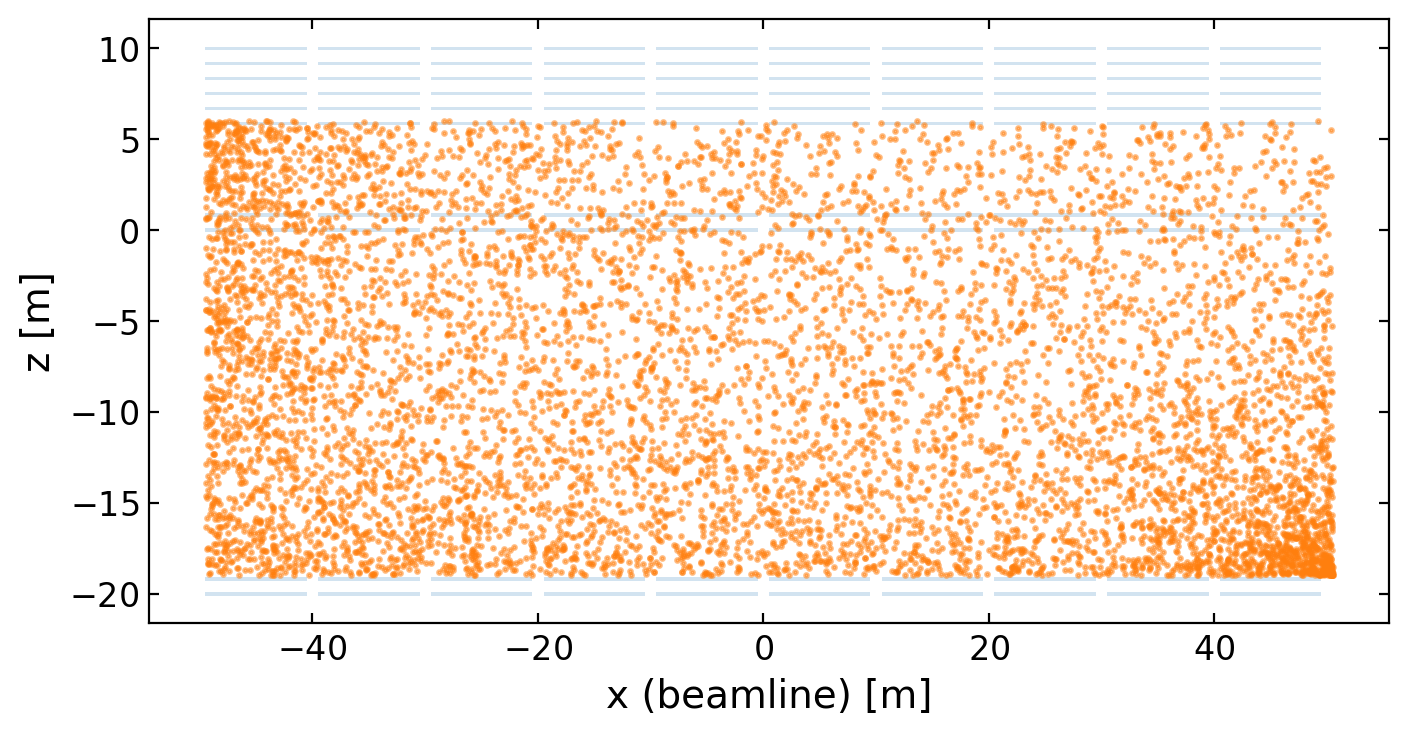

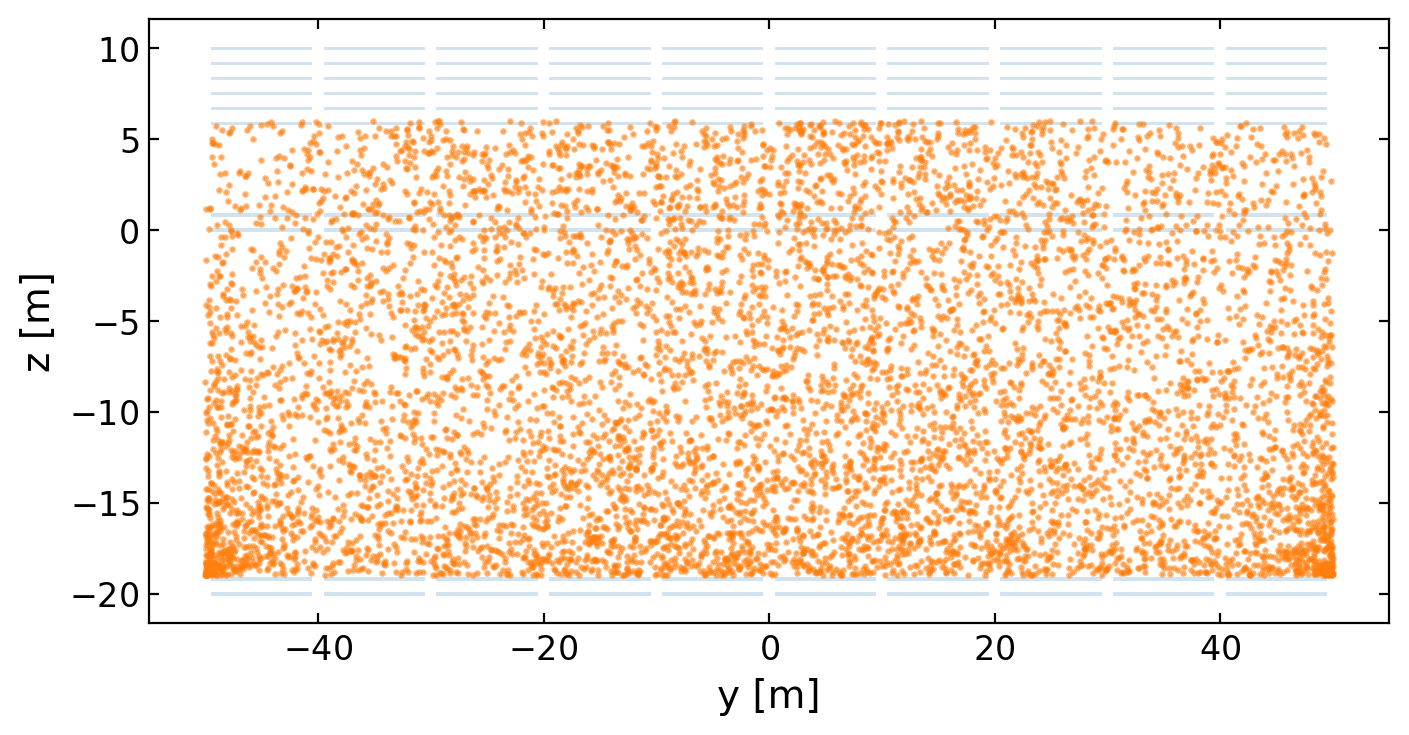

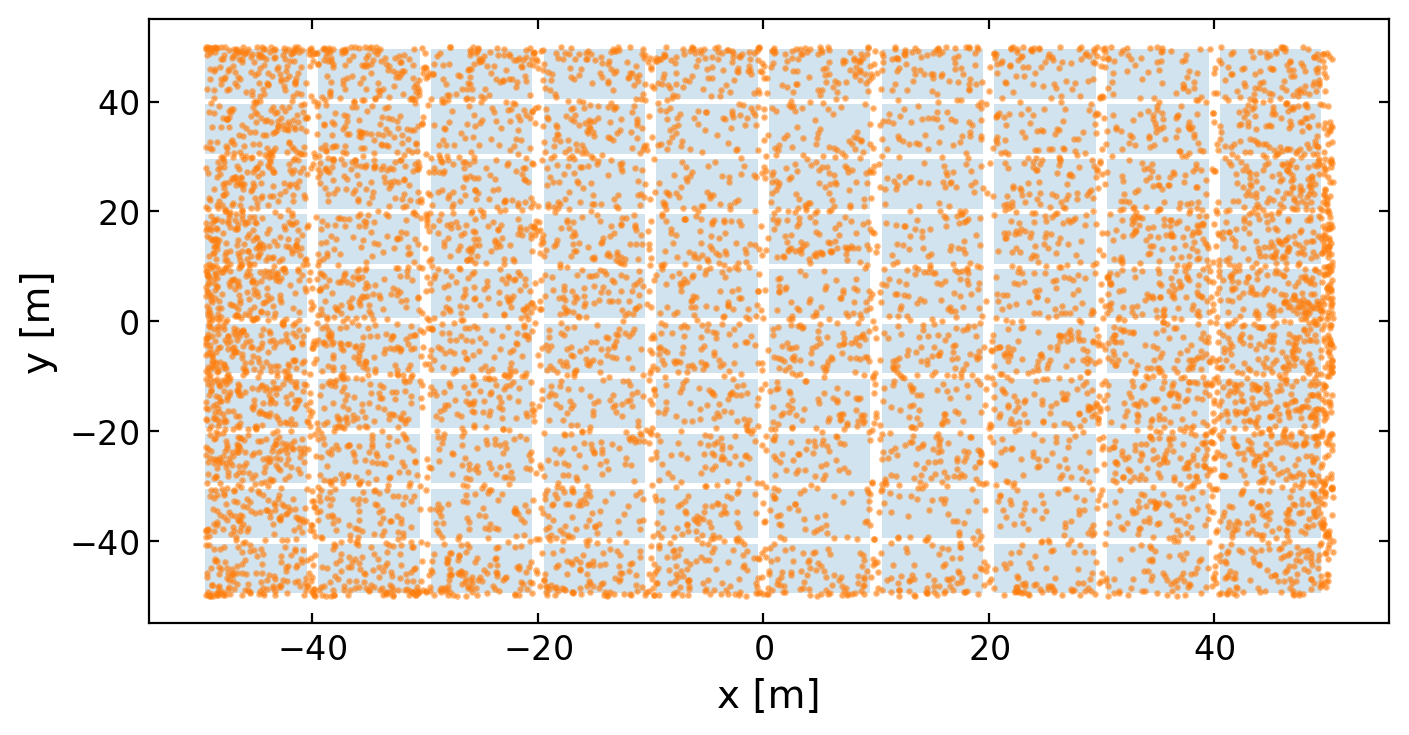

In [10]:
fig,ax=subplots(figsize=(8,4))
vis.drawdet_xz(alpha=0.2)
nplot=8000
scatter(all_vertex[:nplot,0]-70-49.5,-all_vertex[:nplot,2],s=2,alpha=0.5,color="C1")
# xlim(-50,50)
xlabel("x (beamline) [m]")
ylabel("z [m]")
show()

fig,ax=subplots(figsize=(8,4))
vis.drawdet_xz(alpha=0.2)
scatter(all_vertex[:nplot,1],-all_vertex[:nplot,2],s=2,alpha=0.5,color="C1")
# xlim(-50,50)
xlabel("y [m]")
ylabel("z [m]")
show()

fig,ax=subplots(figsize=(8,4))
vis.drawdet_xy(alpha=0.2)
scatter(all_vertex[:nplot,0]-70-49.5,-all_vertex[:nplot,1],s=2,alpha=0.5,color="C1")
# xlim(-50,50)
xlabel("x [m]")
ylabel("y [m]")
show()

### Inspect the simulation

In [3]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
reload(vis)

import lsfit

# Figure save path prefix
savefig.fig_prefix = "plots/vertex2_"    # It's good to keep figures in a separate folder. Can also be set to None.
savefig.SAVE = False         # Use this flag to turn the figure saving on or off, so that you don't need to modify all notebook to save figure.

In [20]:
filename = "scripts/data/20230614/235929/run0.root"
tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print("Number of events",nevents)

Number of events 199


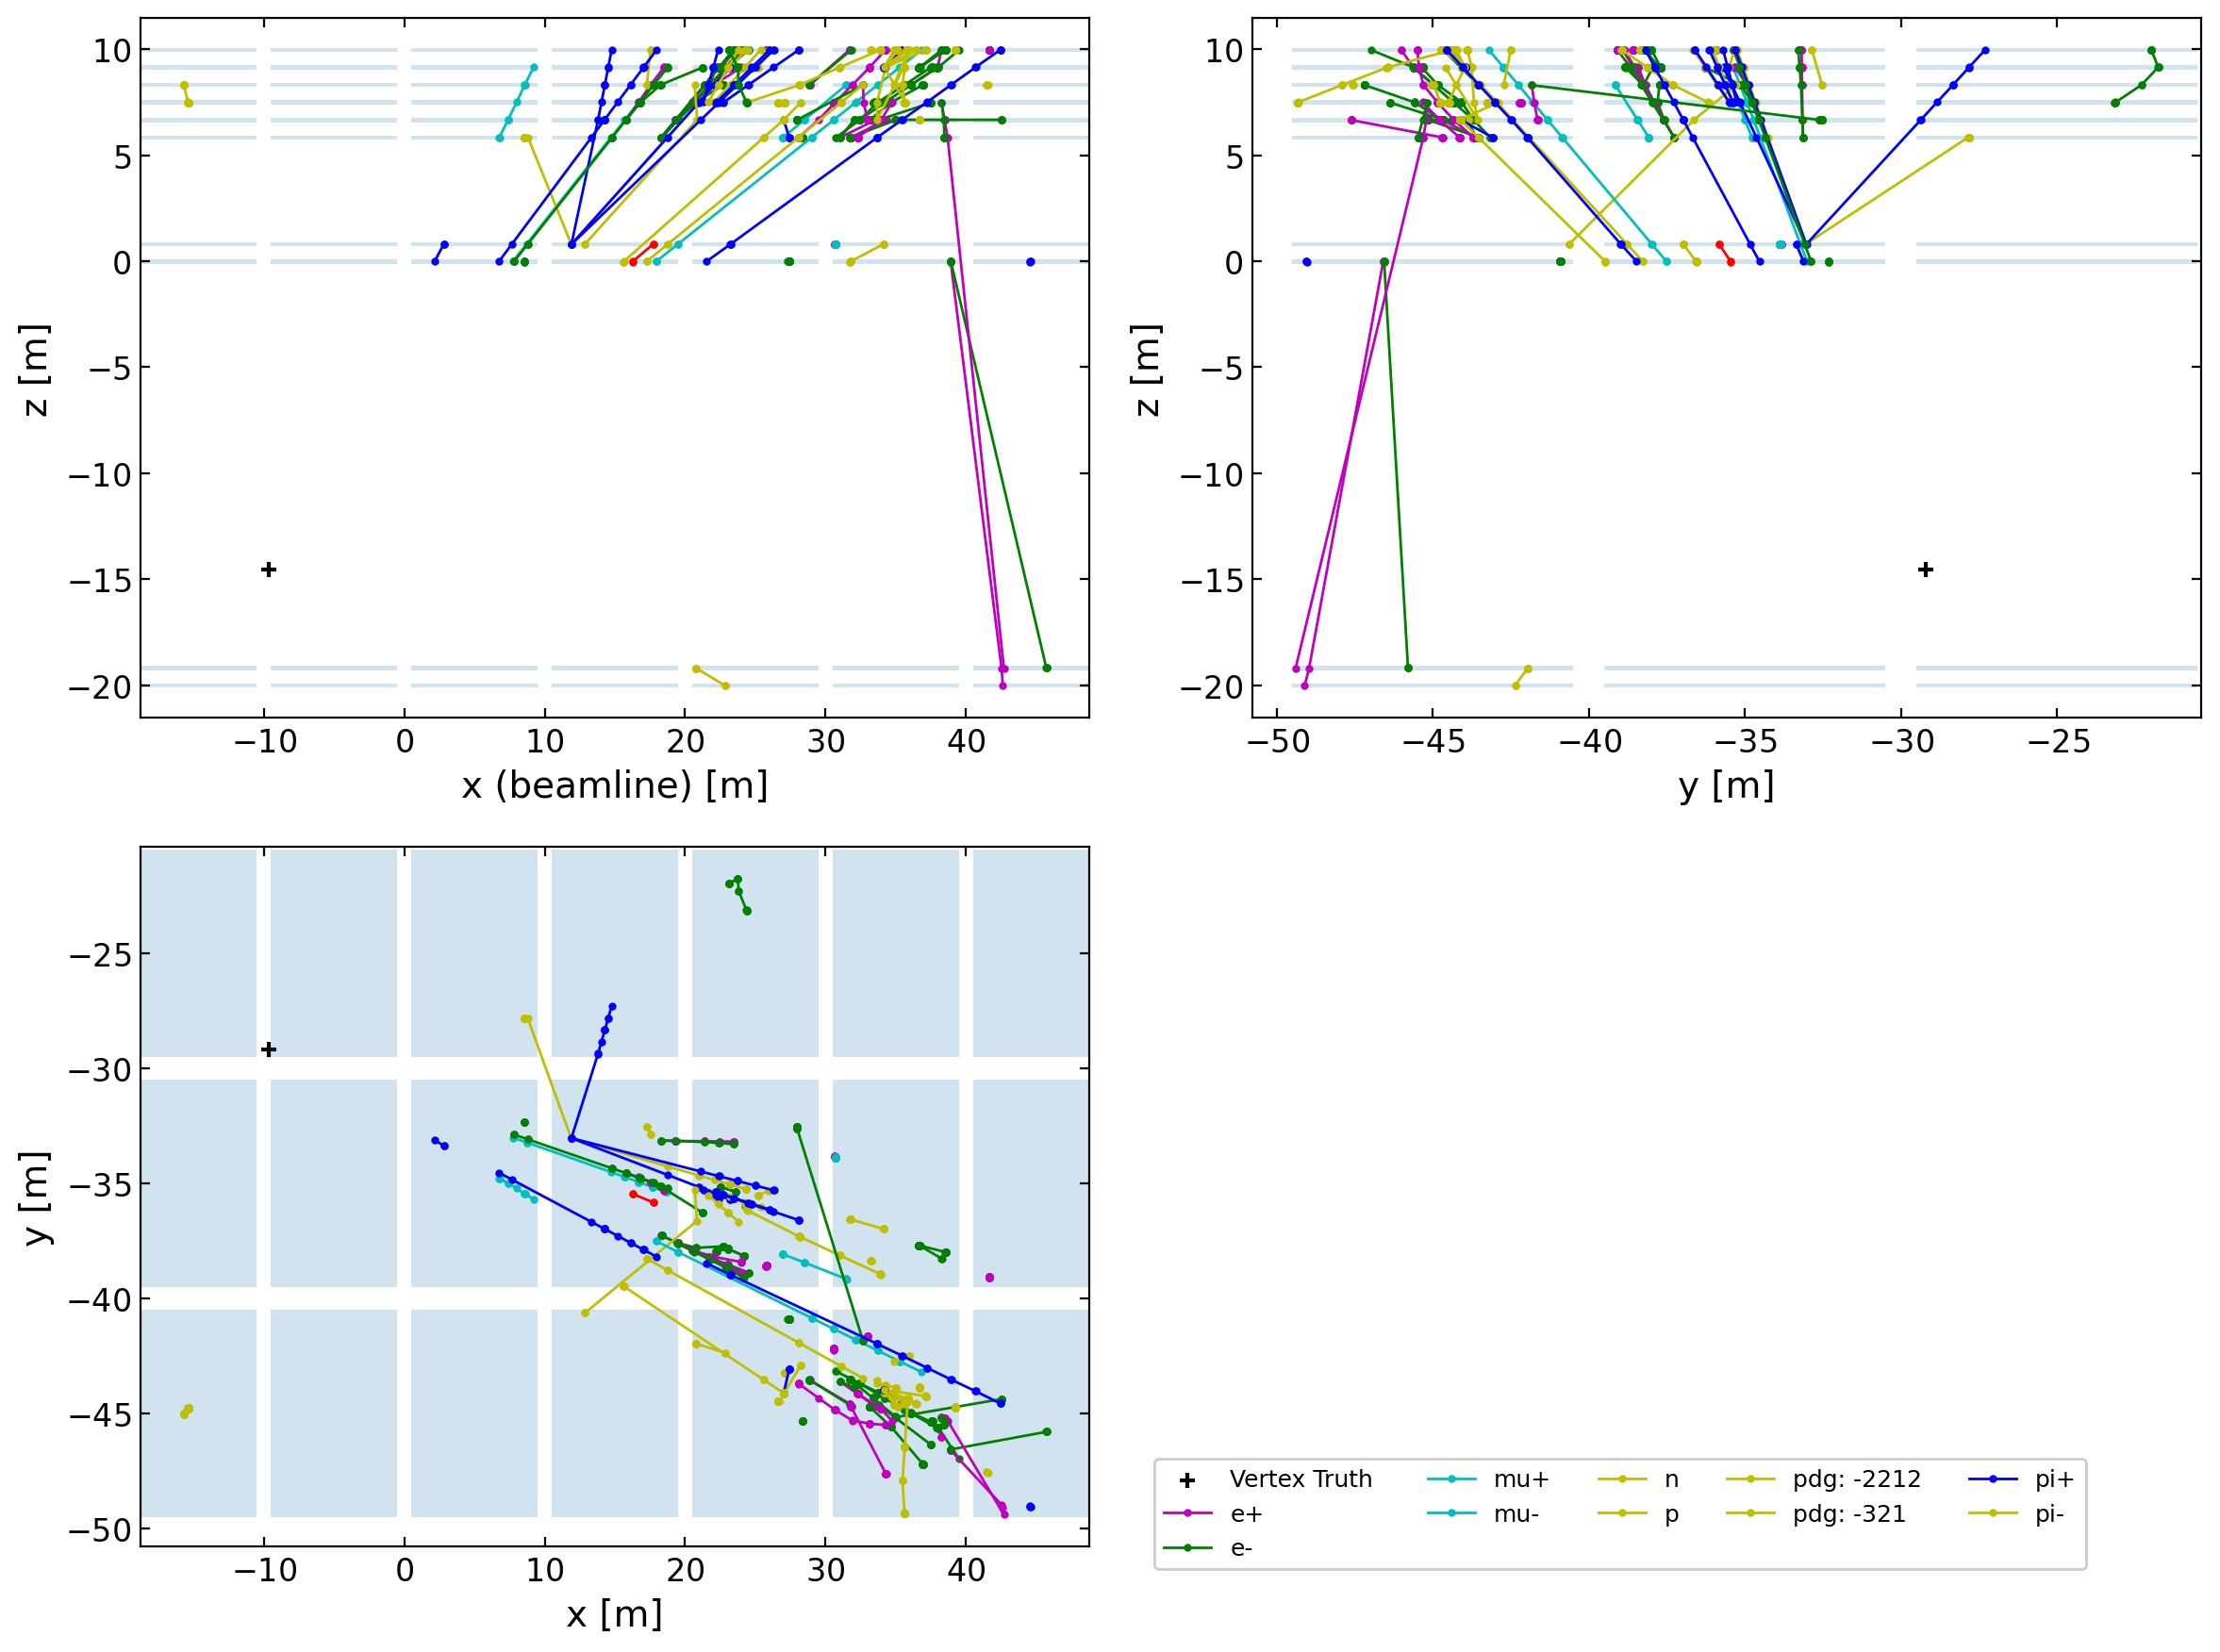

In [68]:
ev = event.Event(filename, 0, tree_name=tree_name)

fig,axs=plt.subplots(2,2,figsize=(12,9))
ev.EventNumber=5
ev.Tree.GetEntry(ev.EventNumber)
vertex_truth = np.array([ev.Tree.GenParticle_x[1]-(70+49.5)*1000,ev.Tree.GenParticle_y[1],-ev.Tree.GenParticle_z[1]])*1e-3
# Plot the truth vertex
axs=fig.axes
axs[0].scatter(vertex_truth[0],vertex_truth[2],color="black",marker="+",label="Vertex Truth ")
axs[1].scatter(vertex_truth[1],vertex_truth[2],color="black",marker="+")
axs[2].scatter(vertex_truth[0],vertex_truth[1],color="black",marker="+",label="Vertex Truth ")


fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_vertex=True, disp_first_hit=False,make_legend=True);


In [4]:
filename = "scripts/data/20230614/235929/stat0.root"
tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print("Number of events",nevents)

Number of events 20


In [41]:
reload(vis.physics)
reload(vis)

<module 'visualization' from '/project/6035200/tomren/jupyter/tracker_6layers/visualization.py'>

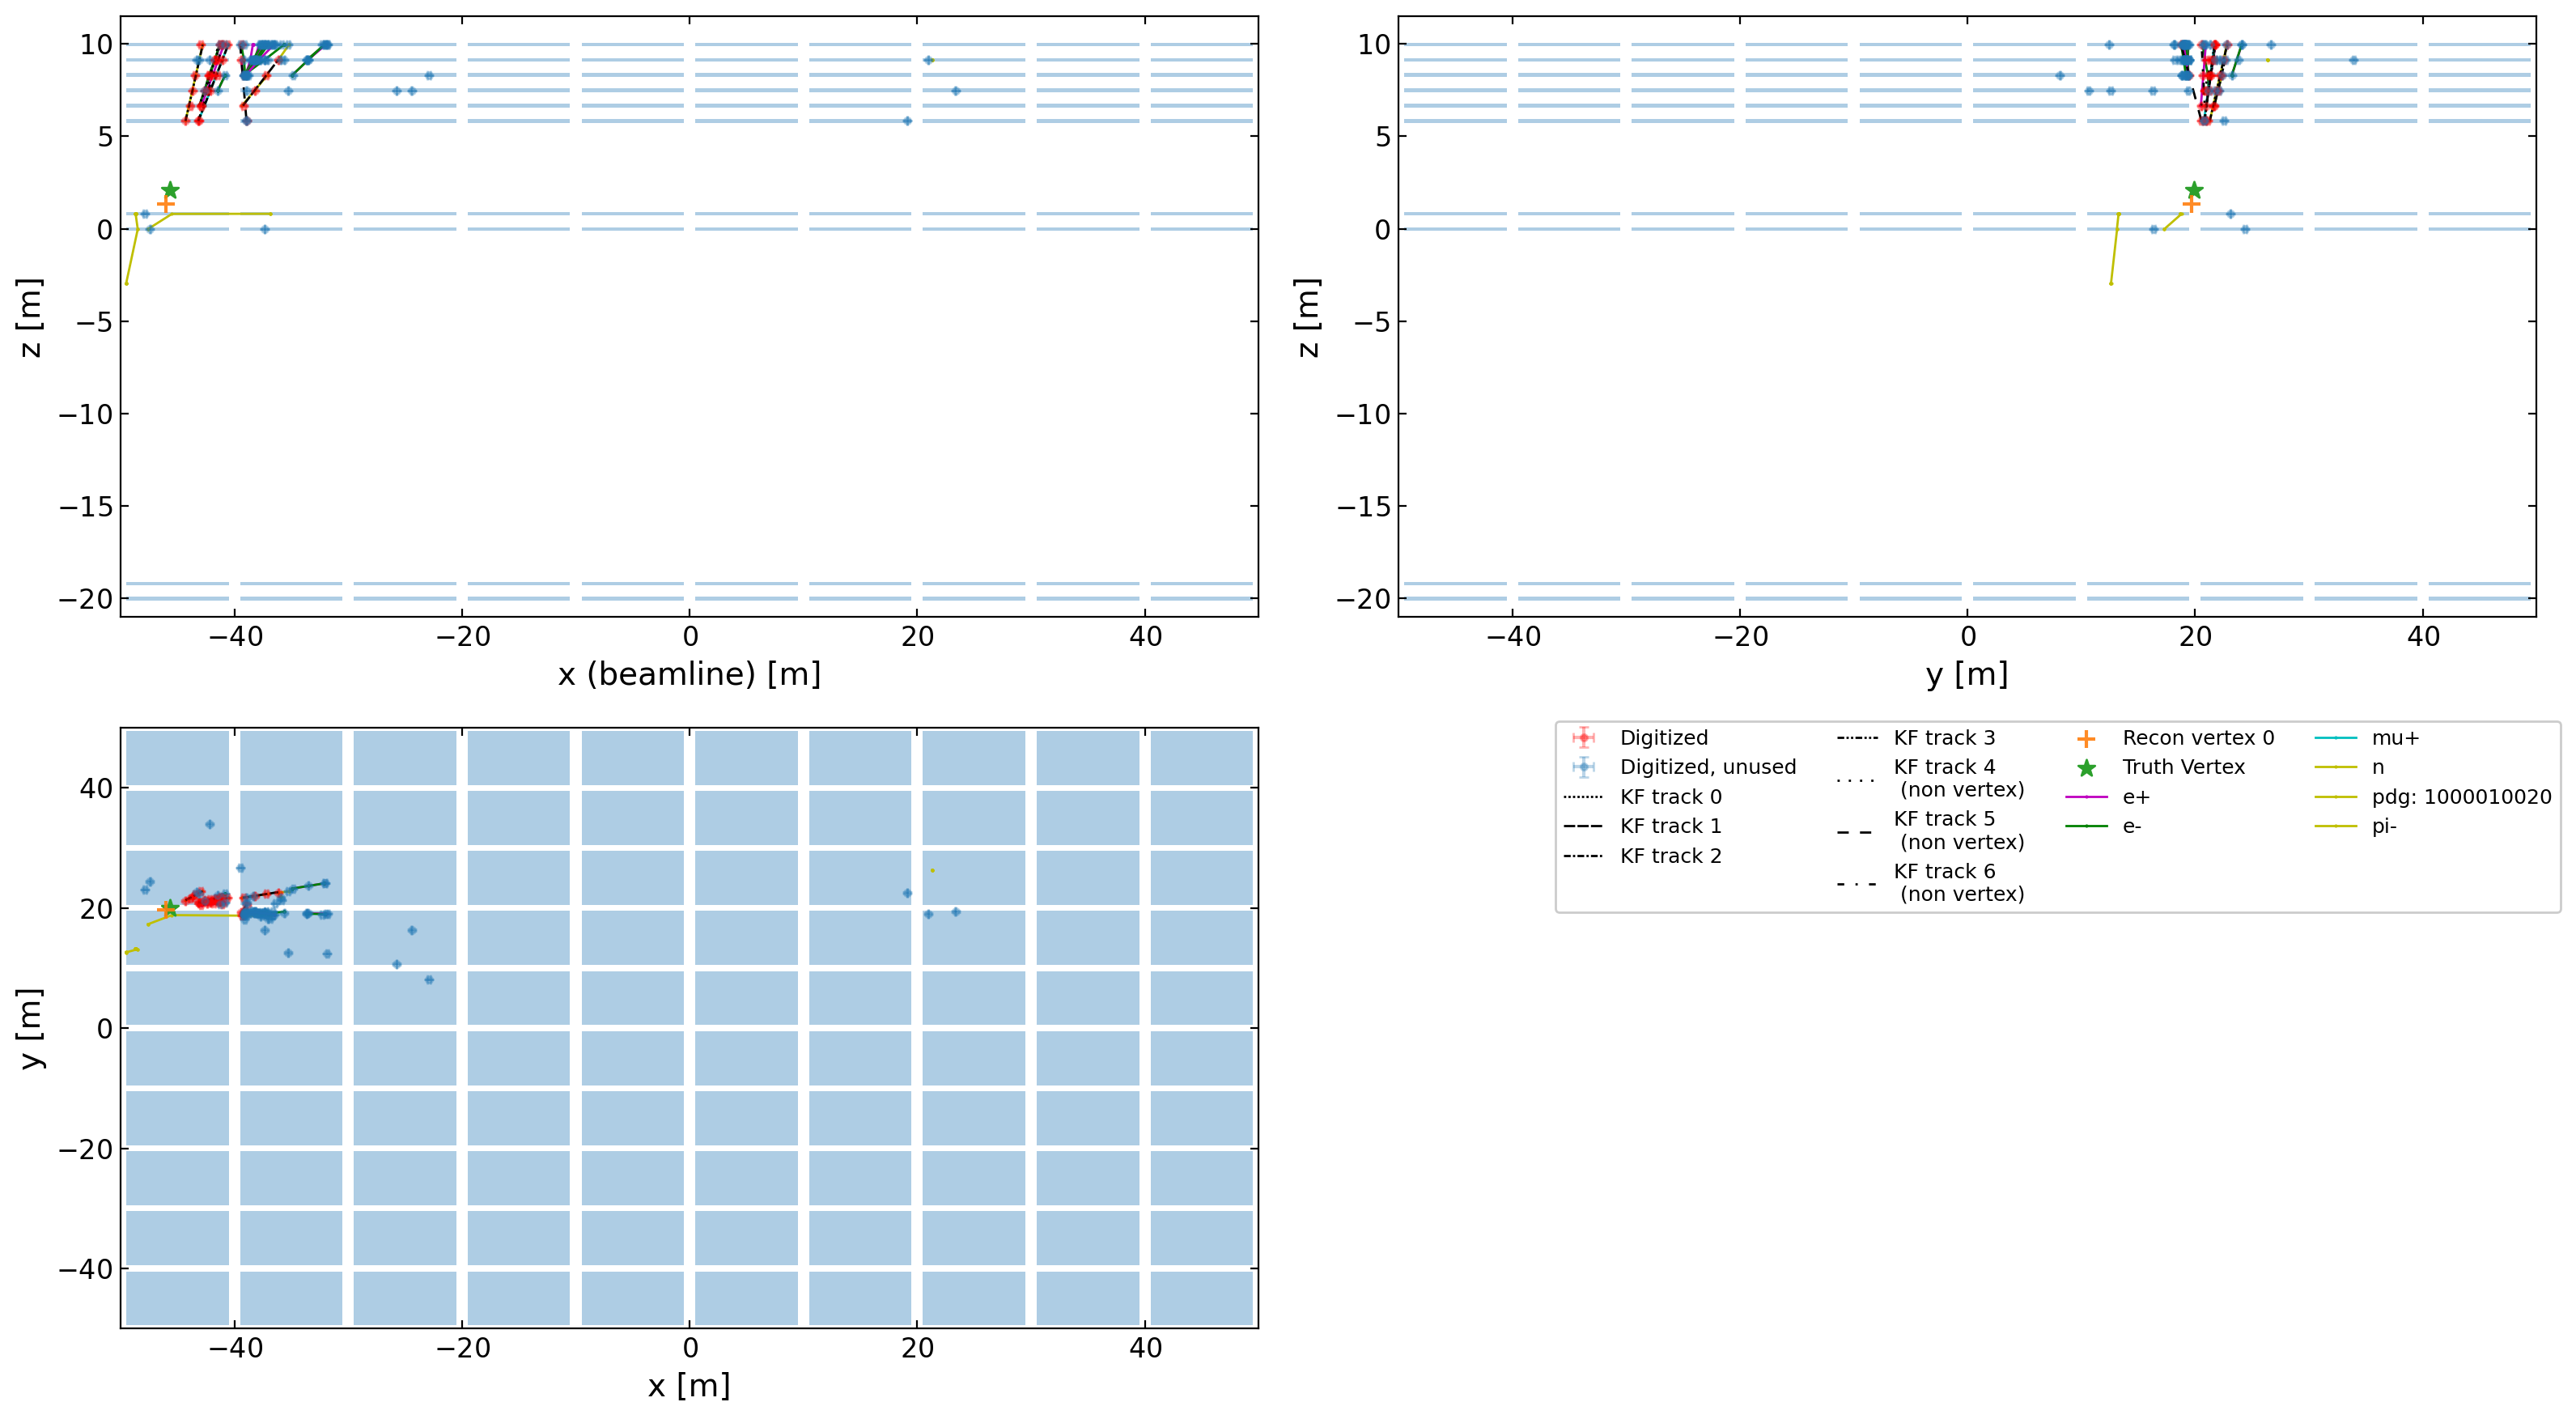

In [24]:
ev = event.Event(filename, 0, tree_name=tree_name)

fig,axs=plt.subplots(2,2,figsize=(16,9))
ev.EventNumber=13
ev.Tree.GetEntry(ev.EventNumber)
vertex_truth = np.array([ev.Tree.GenParticle_x[1]-(70+49.5)*1000,ev.Tree.GenParticle_y[1],-ev.Tree.GenParticle_z[1]])*1e-3
# Plot the truth vertex
axs=fig.axes
# axs[0].scatter(vertex_truth[0],vertex_truth[2],color="black",marker="+",label="Vertex Truth ")
# axs[1].scatter(vertex_truth[1],vertex_truth[2],color="black",marker="+")
# axs[2].scatter(vertex_truth[0],vertex_truth[1],color="black",marker="+",label="Vertex Truth ")


fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_filereader_vertex=True, disp_first_hit=False,make_legend=False);
fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True,force_limit=True,make_legend=True);

### Vertex seed

In [25]:
Tree = ev.Tree
if Tree.Track_k_m_x0.size()>=2:
    tracks = []
    for track_ind in range(Tree.Track_k_m_x0.size()):
        track_1 =np.array([Tree.Track_k_m_x0.at(track_ind), Tree.Track_k_m_y0.at(track_ind), Tree.Track_k_m_z0.at(track_ind),Tree.Track_k_m_velX.at(track_ind), Tree.Track_k_m_velY.at(track_ind), Tree.Track_k_m_velZ.at(track_ind), Tree.Track_k_m_t0.at(track_ind)])
        tracks.append(track_1)

    dists=[]
    residuals=[]
    for i in range(len(tracks)):
        for j in range(i+1, len(tracks)):
            position,t,dist = closest_approach_midpoint(tracks[i],tracks[j])
            dists.append(dist)

In [18]:
util.unzip(ev.Tree.Vertex_k_m_trackIndices)

[[5.0, 12.0, 15.0],
 [2.0, 17.0],
 [9.0, 14.0],
 [3.0, 10.0, 19.0],
 [16.0, 18.0],
 [0.0, 4.0]]

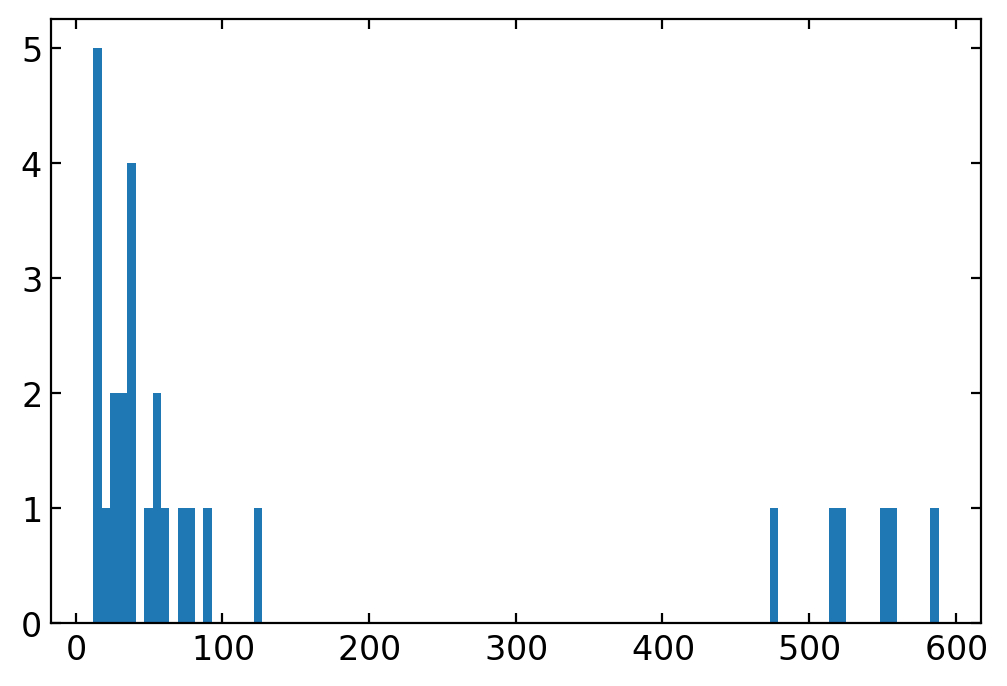

In [27]:
hist(dists);

In [64]:
ev = event.Event(filename, 0, tree_name=tree_name)
ev.EventNumber=9

hits = lsfit.get_digi_hits(ev)
trackid = util.c2list(ev.Tree.Digi_track_id)


dss_abs = []
dss_rel = []
dys=[]
mask_sametrack=[]

c=29.97

for i in range(len(hits)):
    for j in range(i, len(hits)):
        if hits[i].y!=hits[j].y:
            # ds = np.sqrt((hits[i].x-hits[j].x)**2 + (hits[i].y-hits[j].y)**2 + (hits[i].z-hits[j].z)**2)/c/(hits[i].t-hits[j].t) -1 
            ds_abs = ((hits[i].x-hits[j].x)**2 + (hits[i].y-hits[j].y)**2 + (hits[i].z-hits[j].z)**2)/c**2-((hits[i].t-hits[j].t)**2) 
            ds_rel = ((hits[i].x-hits[j].x)**2 + (hits[i].y-hits[j].y)**2 + (hits[i].z-hits[j].z)**2)/c**2/((hits[i].t-hits[j].t)**2) -1 
            dss_abs.append(abs(ds_abs))
            dss_rel.append(abs(ds_rel))
            dys.append(abs(hits[i].y-hits[j].y))
            if trackid[i]==trackid[j]:
                mask_sametrack.append(True)
            else:
                mask_sametrack.append(False)       
                
dss_abs=np.array(dss_abs)
dss_rel=np.array(dss_rel)
mask_sametrack=np.array(mask_sametrack)        
dys=np.array(dys)

In [66]:
dys_unique = np.unique(dys)
print(dys_unique)

[ 82.6  82.6 165.2 165.2 247.8 330.4 413.  502.6 585.2 667.8 750.4 750.4
 833.  915.6 998.2]


(85, 0.47368421052631576, 297, 0.03171439560823805)

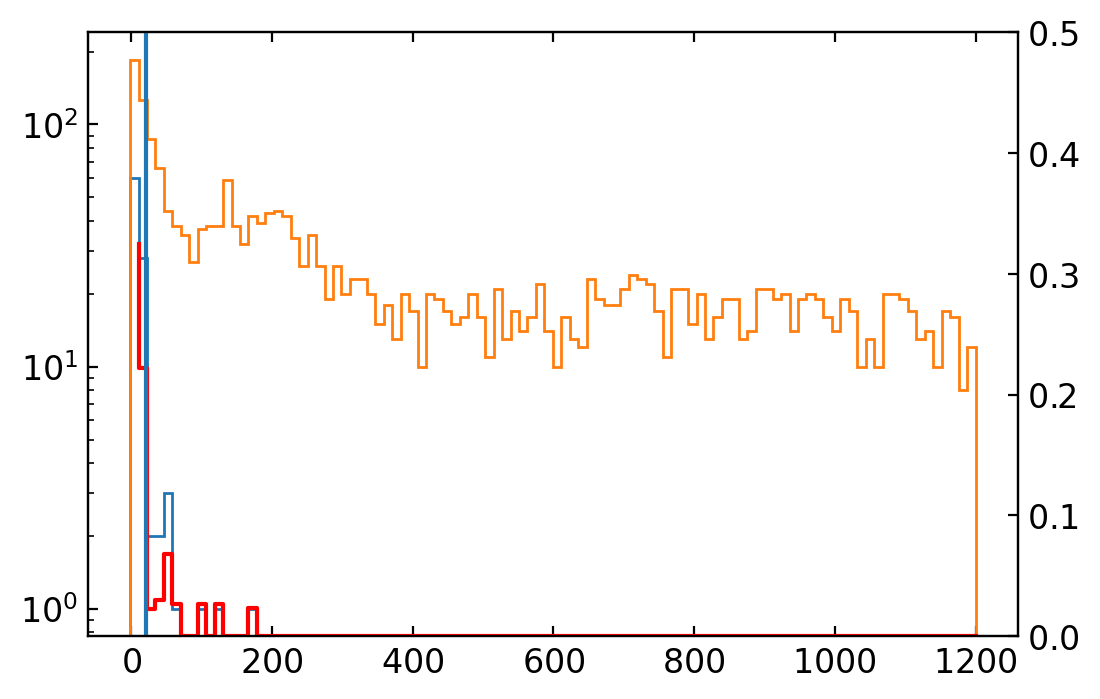

In [88]:
mask_dy = dys==dys_unique[1]
n1,ibins,p = hist(dss_abs[mask_sametrack&mask_dy],range=(-2,1200),histtype="step");
n2,ibins,p = hist(dss_abs[~mask_sametrack&mask_dy],range=(-2,1200),histtype="step");
yscale("log")
axt = gca().twinx()
axt.step(ibins[1:],n1/n2,color="r")
axt.set_ylim(0,0.5)


ds_abs_cut=20
axvline(ds_abs_cut)
sum(mask_sametrack&(dss_abs<ds_abs_cut)&mask_dy), sum(mask_sametrack&(dss_abs<ds_abs_cut))/sum(mask_sametrack),sum(~mask_sametrack&(dss_abs<ds_abs_cut)&mask_dy),sum(~mask_sametrack&(dss_abs<ds_abs_cut))/sum(~mask_sametrack)

(315, 0.8725761772853186, 2719, 0.09507325430959125)

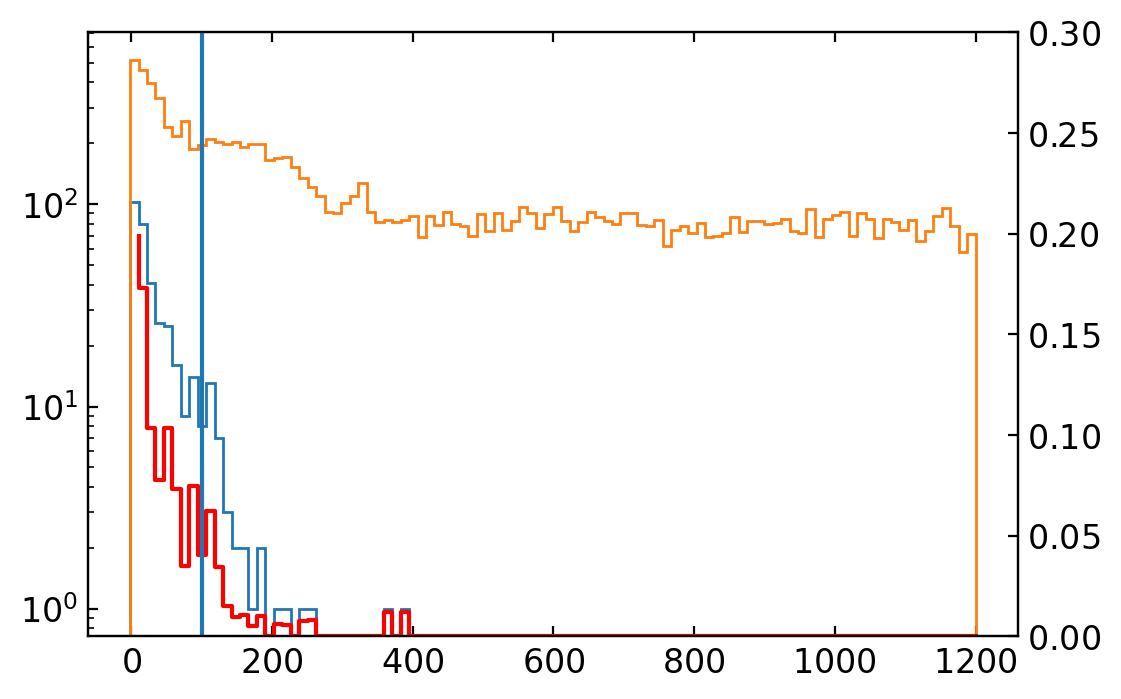

In [61]:
n1,ibins,p = hist(dss_abs[mask_sametrack],range=(-2,1200),histtype="step");
n2,ibins,p = hist(dss_abs[~mask_sametrack],range=(-2,1200),histtype="step");
yscale("log")
axt = gca().twinx()
axt.step(ibins[1:],n1/n2,color="r")
axt.set_ylim(0,0.3)


ds_abs_cut=100
axvline(ds_abs_cut)
sum(mask_sametrack&(dss_abs<ds_abs_cut)), sum(mask_sametrack&(dss_abs<ds_abs_cut))/sum(mask_sametrack),sum(~mask_sametrack&(dss_abs<ds_abs_cut)),sum(~mask_sametrack&(dss_abs<ds_abs_cut))/sum(~mask_sametrack)

/tmp/ipykernel_31592/3464920438.py:6: RuntimeWarning: invalid value encountered in true_divide
  axt.step(ibins[1:],n1/n2,color="r")


(0.9058171745152355, 0.09206615615930627)

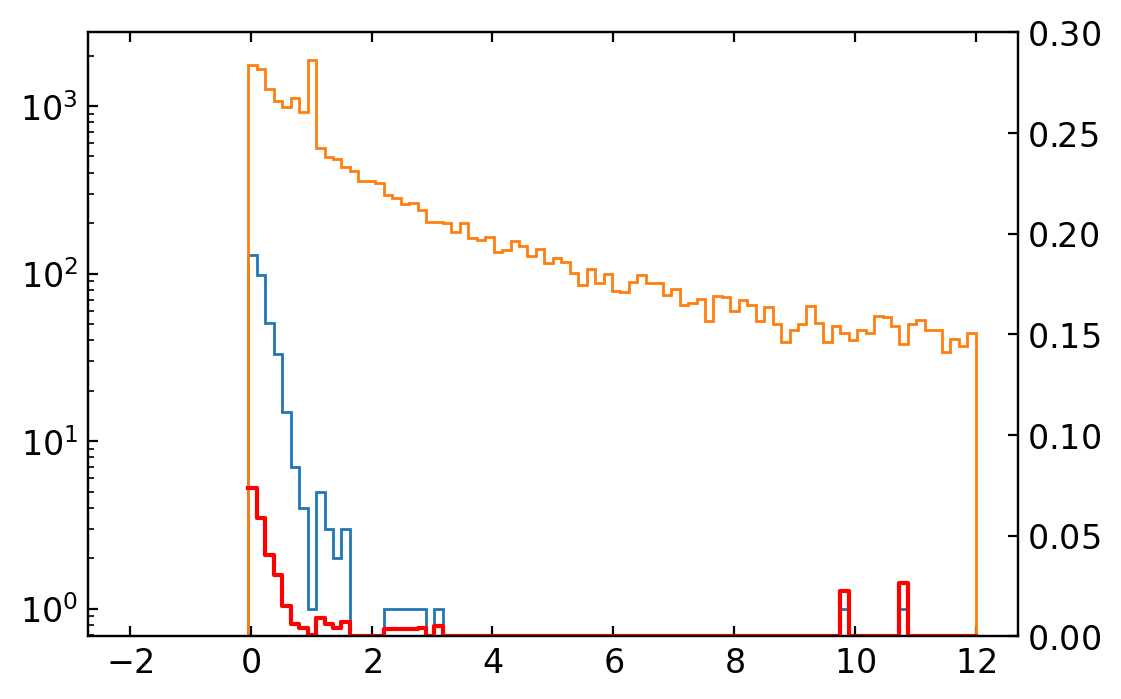

In [57]:
mask_abs = dss_abs<ds_abs_cut
n1,ibins,p = hist(dss_rel[mask_sametrack],range=(-2,12),histtype="step");
n2,ibins,p = hist(dss_rel[~mask_sametrack],range=(-2,12),histtype="step");
yscale("log")
axt = gca().twinx()
axt.step(ibins[1:],n1/n2,color="r")
axt.set_ylim(0,0.3)

# axvline(100)
sum(mask_sametrack&(dss_rel<2)&mask_abs)/sum(mask_sametrack),sum(~mask_sametrack&(dss_rel<2)&mask_abs)/sum(~mask_sametrack)